In [101]:
import numpy as np
from astropy.table import Table, join
from astropy.stats import sigma_clip

suffix = '20260103185816'

t_hsc_ = Table.read('DESI_DR1_HSCSSP_clean_v2.fits')
t_hsc = t_hsc_[((t_hsc_['g_kronflux_mag'] > 0) & 
                (t_hsc_['r_kronflux_mag'] > 0) & 
                (t_hsc_['i_kronflux_mag'] > 0) & 
                (t_hsc_['z_kronflux_mag'] > 0) & 
                (t_hsc_['y_kronflux_mag'] > 0) & 
                (t_hsc_['zwarn'] == 0))]

t_photo = Table.read(f'HSC_SSP_photoz_dnnz.fits')
t_photo = t_photo[['object_id', 'photoz_mean']]
t_dnnz = join(t_hsc, t_photo, keys='object_id', join_type='inner')

t_photo = Table.read(f'HSC_SSP_photoz_demp.fits')
t_photo = t_photo[['object_id', 'photoz_mean']]
t_demp = join(t_hsc, t_photo, keys='object_id', join_type='inner')

t_photo = Table.read(f'HSC_SSP_photoz_mizuki.fits')
t_photo = t_photo[['object_id', 'photoz_mean']]
t_miz = join(t_hsc, t_photo, keys='object_id', join_type='inner')


t_photo = Table.read(f'HSC_SSP_zphoto_{suffix}.fits')
t_photo['photoz_mean'] = t_photo['z_photo']
t_photo = t_photo[['object_id', 'photoz_mean']]
t_vae = join(t_hsc, t_photo, keys='object_id', join_type='inner')

t_photo = Table.read(f'HSC_SSP_zphoto.fits')
t_photo['photoz_mean'] = t_photo['z_photo']
t_photo = t_photo[['object_id', 'photoz_mean']]
t_vae_old = join(t_hsc, t_photo, keys='object_id', join_type='inner')



In [102]:
def calc_scatter(t, N=20):
    plx = t['z']
    ply = t['photoz_mean']-t['z']
    bins = np.linspace(np.min(plx), np.max(plx), N + 1)
    indices = np.digitize(plx, bins)
    z_mean_arr = []
    mean_val_arr = []
    std_val_arr = []
    corrected_ply = ply.copy()
    for i in range(1, N + 1):
        bin_mask = indices == i
        if np.any(bin_mask):
            clipped = sigma_clip(ply[bin_mask], sigma=1.50, maxiters=20)
            mean_val = np.median(clipped.data[~clipped.mask])
            std_val = np.nanstd(clipped.data[~clipped.mask])
            #print(np.mean(plx[bin_mask]), mean_val, std_val)
            corrected_ply[bin_mask] -= mean_val
            z_mean_arr.append(np.mean(plx[bin_mask]))
            mean_val_arr.append(mean_val)
            std_val_arr.append(std_val)
    return z_mean_arr, mean_val_arr, std_val_arr

/home/kirg/envs/envp3.12/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:870: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/kirg/envs/envp3.12/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:870: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/kirg/envs/envp3.12/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:870: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/kirg/envs/envp3.12/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:870: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/kirg/envs/envp3.12/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:870: UserWarning: Warning: 'partition' will ignore 

(0.0, 0.005)

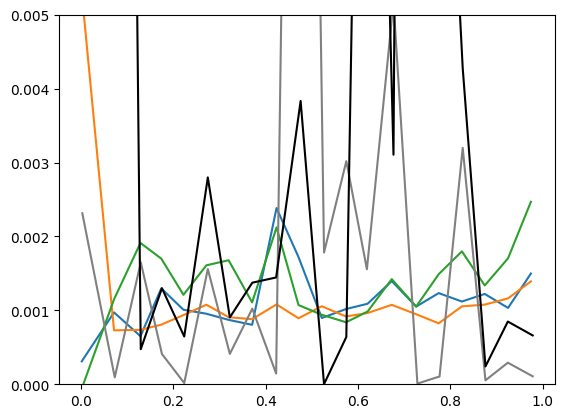

In [105]:
z_max = 1.00
t_ = t_dnnz[t_dnnz['z'] < z_max]
z, mean, std = calc_scatter(t_, N=20)
plt.plot(z, std)

t_ = t_demp[t_demp['z'] < z_max]
z, mean, std = calc_scatter(t_, N=20)
plt.plot(z, std)

t_ = t_miz[t_miz['z'] < z_max]
z, mean, std = calc_scatter(t_, N=20)
plt.plot(z, std)

t_ = t_vae_old[t_vae_old['z'] < z_max]
z, mean, std = calc_scatter(t_, N=20)
plt.plot(z, std, color='grey')

t_ = t_vae[t_vae['z'] < z_max]
z, mean, std = calc_scatter(t_, N=20)
plt.plot(z, std, color='black')

plt.ylim(0, 0.005)


0.013146586187250122 6.577473973588864e-05 0.0003268012795842736
0.10211052801625448 0.01053560900513574 0.03422373764461325
0.1705661512010484 -0.015360141072156774 0.03589522126881895
0.24166331653121617 -0.031268815293175115 0.033867905883410473
0.30812885651503846 -0.035109076299086384 0.05207911292146615
0.37776234675888615 -0.024628990140823925 0.02632884147298614
0.4475543332965372 -0.03924708638844748 0.06398065255497998
0.5208432234127602 0.004690939390681381 0.02833014260410793
0.5927216965205703 0.002990001483313409 0.021383130594042565
0.663634136362436 -0.01469694393497123 0.028713777077351378
0.7361367519790019 -0.022826682802849996 0.026291898005148147
0.8040983506861337 -0.017938975857732298 0.045533961960050565
0.872324684775982 -0.00244601900387742 0.03223624717715692
0.9424903298682178 -0.008321037741067572 0.043975674668579386
1.0127473205161581 -0.007719665445340584 0.04454102075405762
1.081635106667596 -0.009002986911277655 0.04719361945997635
1.1538976628350668 -

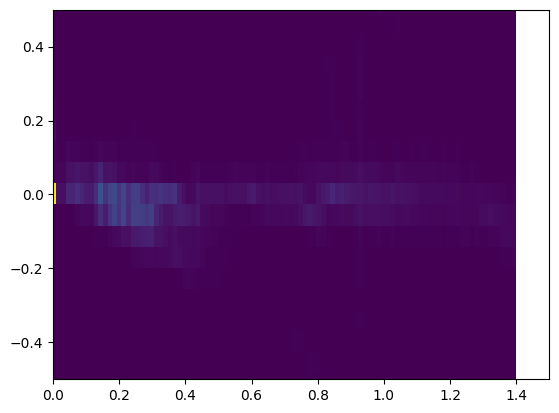

In [90]:
import matplotlib.pyplot as plt

t = t[t['z'] < 1.4]

plx = t['z']
ply = t['photoz_mean']-t['z']
filt = np.isfinite(plx) & np.isfinite(ply)
plt.hist2d(plx[filt], ply[filt], bins=100)
plt.xlim(0, 1.5)
plt.ylim(-0.5, 0.5)



N = 20
# Digitize plx into N bins
bins = np.linspace(np.min(plx), np.max(plx), N + 1)
indices = np.digitize(plx, bins)

# Subtract sigma-clipped mean of ply in each bin
corrected_ply = ply.copy()
for i in range(1, N + 1):
    bin_mask = indices == i
    if np.any(bin_mask):
        clipped = sigma_clip(ply[bin_mask], sigma=2.5, maxiters=20)
        mean_val = np.median(clipped.data[~clipped.mask])
        std_val = np.nanstd(clipped.data[~clipped.mask])
        print(np.mean(plx[bin_mask]), mean_val, std_val)
        corrected_ply[bin_mask] -= mean_val




